# Sentimental Analysis on Tweets

## 1. Getting Data Ready


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import string
from csv import DictWriter

sns.set_style('whitegrid')

In [2]:
fr = pd.read_csv("combine-final.csv",encoding='latin1')
fr.head()

,Tweet Posted Time (UTC),Tweet Content,Tweet Location
0,01/03/2020,Why .Indians to prayer Iran a polluted http://...,Bihar
1,01/03/2020,Even death is âMade in Chinaâ now #CoronaV...,Goa
2,01/03/2020,One of the most widely read published stories...,Goa
3,01/03/2020,Hahahh RAW mission in Iran is failed due to C...,Punjab
4,01/03/2020,#BreakingNews: in show @sawaalwithamber on @SA...,Punjab


In [3]:
state_list  = fr['Tweet Location'].unique()
state_set  = set(state_list)
state_set

{'Ahmedabad',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bangalore',
 'Bhubaneswar',
 'Bihar',
 'Chandigarh',
 'Chennai',
 'Chhattisgarh',
 'Dadra and Nagar Haveli',
 'Daman and Diu',
 'Dehradun',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Hyderabad',
 'Indore',
 'Jaipur',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Kochi',
 'Kolkata',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Mumbai',
 'Nagaland',
 'Orissa',
 'Pondicherry',
 'Pune',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tirupati',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'Visakhapatnam',
 'West Bengal'}

In [4]:
fr['Tweet Posted Time (UTC)'].unique()

array(['01/03/2020', '02/03/2020', '03/03/2020', '04/03/2020',
       '05/03/2020', '06/03/2020', '07/03/2020', '08/03/2020',
       '09/03/2020', '10/03/2020', '11/03/2020', '12/03/2020',
       '13/03/2020', '14/03/2020', '15/03/2020', '16/03/2020',
       '17/03/2020', '18/03/2020', '19/03/2020', '20/03/2020',
       '21/03/2020', '22/03/2020', '23/03/2020', '24/03/2020',
       '25/03/2020', '26/03/2020', '27/03/2020', '28/03/2020',
       '29/03/2020', '30/03/2020', '31/03/2020', '01/04/2020',
       '02/04/2020', '03/04/2020', '04/04/2020', '05/04/2020',
       '06/04/2020', '07/04/2020', '08/04/2020', '09/04/2020',
       '10/04/2020', '11/04/2020', '12/04/2020', '13/04/2020',
       '14/04/2020', '15/04/2020', '16/04/2020', '17/04/2020',
       '18/04/2020', '19/04/2020', '20/04/2020', '21/04/2020',
       '22/04/2020', '23/04/2020', '24/04/2020', '25/04/2020',
       '26/04/2020', '27/04/2020', '28/04/2020', '29/04/2020',
       '30/04/2020', '01/05/2020', '02/05/2020', '03/05

for st in state_set:
    location = fr.loc[fr['Tweet Location']== st ]
    location.to_csv(str(st) + ".csv" , index = True)


# 2. Getting NRC Dataframe Ready!

In [5]:
import pandas as pd
filepath = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
emolex_df= emolex_df[emolex_df['association']==1]
emolex_df.head()

,word,emotion,association
40,abacus,trust,1.0
44,abandon,fear,1.0
46,abandon,negative,1.0
48,abandon,sadness,1.0
51,abandoned,anger,1.0


In [6]:
emolex_df.emotion.unique()

array(['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise',
       'positive', 'disgust', 'joy', 'anticipation'], dtype=object)

In [7]:
emolex_df.emotion.value_counts()

negative        3324
positive        2312
fear            1476
anger           1247
trust           1231
sadness         1191
disgust         1058
anticipation     839
joy              689
surprise         534
Name: emotion, dtype: int64

In [8]:
emolex_df[emolex_df.association == 1].emotion.value_counts()

negative        3324
positive        2312
fear            1476
anger           1247
trust           1231
sadness         1191
disgust         1058
anticipation     839
joy              689
surprise         534
Name: emotion, dtype: int64

In [9]:
emolex_df[(emolex_df.association == 1) & (emolex_df.emotion == 'anger')].word

51          abandoned
61        abandonment
191             abhor
201         abhorrent
291           abolish
             ...     
141241       wrongful
141251        wrongly
141491           yell
141521           yelp
141661          youth
Name: word, Length: 1247, dtype: object

In [10]:
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_words.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,abandon,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2,abandoned,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
3,abandonment,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN
4,abba,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [11]:
# If you didn't reset_index you could do this more easily
# by doing emolex_words.loc['charitable']
emolex_words[emolex_words.word == 'charitable']

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
910,charitable,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0


In [12]:
emolex_words[emolex_words.anger==1].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
2,abandoned,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
3,abandonment,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN
9,abhor,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
10,abhorrent,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
14,abolish,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [13]:
emolex_words[(emolex_words.joy == 1) & (emolex_words.negative == 1)].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
35,abundance,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0
495,balm,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
676,boisterous,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
878,celebrity,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0
913,charmed,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN


In [14]:
# Angry words
emolex_words[emolex_words.anger == 1].word

2         abandoned
3       abandonment
9             abhor
10        abhorrent
14          abolish
           ...     
6449       wrongful
6450        wrongly
6457           yell
6459           yelp
6462          youth
Name: word, Length: 1247, dtype: object

In [15]:
emolex_words

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,abandon,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
2,abandoned,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
3,abandonment,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN
4,abba,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6463,zany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
6464,zeal,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0
6465,zealous,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0
6466,zest,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0


In [16]:
emotions = ['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise','trust']
for i in emotions:
    emolex_words[i].fillna(0,inplace=True)

In [17]:
# NRC Dataframe Ready
emolex_words

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6463,zany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6464,zeal,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
6465,zealous,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6466,zest,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [18]:
emotion_anger = list(emolex_words['anger'])
emotion_anticipation = list(emolex_words['anticipation'])
emotion_disgust = list(emolex_words['disgust'])
emotion_fear = list(emolex_words['fear'])
emotion_joy = list(emolex_words['joy'])
emotion_negative = list(emolex_words['negative'])
emotion_positive = list(emolex_words['positive'])
emotion_sadness = list(emolex_words['sadness'])
emotion_surprise = list(emolex_words['surprise'])
emotion_trust = list(emolex_words['trust'])

In [19]:
emotion_word = list(emolex_words['word'])

In [20]:
emotion_word[1000:6000]

['closure',
 'clothe',
 'clouded',
 'cloudiness',
 'cloudy',
 'clown',
 'clue',
 'clump',
 'clumsy',
 'coach',
 'coalesce',
 'coalition',
 'coast',
 'coax',
 'cobra',
 'cocaine',
 'coerce',
 'coercion',
 'coexist',
 'coexisting',
 'coffin',
 'cogent',
 'cognitive',
 'coherence',
 'coherent',
 'cohesion',
 'cohesive',
 'coincidence',
 'cold',
 'coldly',
 'coldness',
 'colic',
 'collaborator',
 'collapse',
 'collateral',
 'collectively',
 'collision',
 'collusion',
 'colonel',
 'colossal',
 'coma',
 'comatose',
 'combat',
 'combatant',
 'combative',
 'comfort',
 'coming',
 'commandant',
 'commanding',
 'commemorate',
 'commemoration',
 'commemorative',
 'commend',
 'commendable',
 'commentator',
 'commerce',
 'commission',
 'committal',
 'committed',
 'committee',
 'commodore',
 'commonplace',
 'commonwealth',
 'commotion',
 'communicate',
 'communication',
 'communicative',
 'communion',
 'communism',
 'communist',
 'community',
 'commutation',
 'commute',
 'compact',
 'companion',
 'co

# 3. Reading CSV Start!

In [21]:
state = ['Ahmedabad',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bangalore',
 'Bhubaneswar',
 'Bihar',
 'Chandigarh',
 'Chennai',
 'Chhattisgarh',
 'Dadra and Nagar Haveli',
 'Daman and Diu',
 'Dehradun',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Hyderabad',
 'Indore',
 'Jaipur',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Kochi',
 'Kolkata',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Mumbai',
 'Nagaland',
 'Orissa',
 'Pondicherry',
 'Pune',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tirupati',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'Visakhapatnam',
 'West Bengal']
tweet_location = []
for i in range(len(state)):
    tweet_location.append(state[i] + '.csv')
tweet_location


['Ahmedabad.csv',
 'Andaman and Nicobar Islands.csv',
 'Andhra Pradesh.csv',
 'Arunachal Pradesh.csv',
 'Assam.csv',
 'Bangalore.csv',
 'Bhubaneswar.csv',
 'Bihar.csv',
 'Chandigarh.csv',
 'Chennai.csv',
 'Chhattisgarh.csv',
 'Dadra and Nagar Haveli.csv',
 'Daman and Diu.csv',
 'Dehradun.csv',
 'Delhi.csv',
 'Goa.csv',
 'Gujarat.csv',
 'Haryana.csv',
 'Himachal Pradesh.csv',
 'Hyderabad.csv',
 'Indore.csv',
 'Jaipur.csv',
 'Jharkhand.csv',
 'Karnataka.csv',
 'Kerala.csv',
 'Kochi.csv',
 'Kolkata.csv',
 'Madhya Pradesh.csv',
 'Maharashtra.csv',
 'Manipur.csv',
 'Meghalaya.csv',
 'Mizoram.csv',
 'Mumbai.csv',
 'Nagaland.csv',
 'Orissa.csv',
 'Pondicherry.csv',
 'Pune.csv',
 'Punjab.csv',
 'Rajasthan.csv',
 'Sikkim.csv',
 'Tamil Nadu.csv',
 'Telangana.csv',
 'Tirupati.csv',
 'Tripura.csv',
 'Uttar Pradesh.csv',
 'Uttarakhand.csv',
 'Visakhapatnam.csv',
 'West Bengal.csv']

In [22]:
stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
                      "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
                      "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
                      "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
                      "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
                      "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
                      "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
                      "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
                      "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
                      "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [23]:
def csv_read(state,csv_name):
    
       
    df = pd.read_csv(csv_name,encoding='latin1')
        

        
        
        #lowerCase
    df['Tweet Content'] = df['Tweet Content'].map(lambda x:str(x).lower())

        #user mention removes
    df['Tweet Content'] = df['Tweet Content'].str.replace(r'@\S+', '')

        #removes reTweet Content & cc
    df['Tweet Content'] = df['Tweet Content'].str.replace(r'rt|cc', '')

        #remove special characters except [a-zA-Z]
    df['Tweet Content'] = df['Tweet Content'].map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))

        #remove link starts with https
    df['Tweet Content'] = df['Tweet Content'].map(lambda x:re.sub('http.*','',str(x)))

    df['Tweet Content'] = df['Tweet Content'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')

        #punctuation
    df['Tweet Content'] = df['Tweet Content'].str.replace('[{}]'.format(string.punctuation), '')


    

        # it include stopwords
    tweet_words = []
    for i in df['Tweet Content']:
        for j in i.split():
            tweet_words.append(j)
    

        # here we remove stopwords
    fwords = []
    for i in tweet_words:
        if i not in stop:
            fwords.append(i)
    swords=list(set(fwords))
        # repetition removed and stored in swords
        

        # the terms common between Tweet Content and nrc
    common_words_emotion = list(set(emotion_word).intersection(set(fwords)))
        

    NRC_words = []
    for i in emolex_words['word']:
        NRC_words.append(i)
        

        # Create your dictionary class  
    class my_dictionary(dict):  

            # __init__ function  
        def __init__(self):  
            self = dict()  

            # Function to add key:value  
        def add(self, key, value):  
            self[key] = value  

    def CountFrequency(my_list):
        dict_obj = my_dictionary() 
        for i in my_list:
            j = fwords.count(i)
                # Taking input key = 1, value = Geek 
            dict_obj.key = i
            dict_obj.value = j
            dict_obj.add(dict_obj.key, dict_obj.value) 
        return dict_obj

    

    dictionary_emotion = CountFrequency(common_words_emotion)
       

    anger=0
    anticipation=0
    disgust=0
    fear=0
    joy=0
    sadness=0
    surprise=0
    trust=0

    for row in emolex_words.itertuples():
        for key,value in dictionary_emotion.items():
            if row[1] in key:
                if (row.anger == 1):
                    anger += 1
                if (row.anticipation == 1):
                    anticipation += 1
                if (row.disgust == 1):
                    disgust += 1
                if (row.fear == 1):
                    fear += 1
                if (row.joy == 1):
                    joy +=1
                if (row.sadness == 1):
                    sadness += 1
                if (row.surprise == 1):
                    surprise += 1
                if (row.trust == 1):
                    trust += 1

    state_emotion_count_dictionary = {
            'state':state,
            'anger':anger,
            'anticipation':anticipation,
            'disgust':disgust,
            'fear':fear,
            'joy':joy,
            'sadness':sadness,
            'surprise':surprise,
            'trust':trust
        }
        
   
    field_names =['state','anger','anticipation', 'disgust','fear', 'joy','sadness','surprise','trust']
    def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
        with open(file_name, 'a+', newline='') as write_obj:
            # Create a writer object from csv module
            dict_writer = DictWriter(write_obj, fieldnames=field_names)
            # Add dictionary as wor in the csv
            dict_writer.writerow(dict_of_elem)
    append_dict_as_row('state_emotion_count.csv',state_emotion_count_dictionary,field_names)
    



for i in state:
    csv_read(i,i+'.csv')

In [24]:
#Reading the shape file
fp = r'Indian_States.shp'
map_df = gpd.read_file(fp)
map_df.head(10)
map_df['st_nm']

0     Andaman & Nicobar Island
1           Arunanchal Pradesh
2                        Assam
3                        Bihar
4                   Chandigarh
5                 Chhattisgarh
6       Dadara & Nagar Havelli
7                  Daman & Diu
8                          Goa
9                      Gujarat
10                     Haryana
11            Himachal Pradesh
12             Jammu & Kashmir
13                   Jharkhand
14                   Karnataka
15                      Kerala
16                 Lakshadweep
17              Madhya Pradesh
18                 Maharashtra
19                     Manipur
20                   Meghalaya
21                     Mizoram
22                    Nagaland
23                NCT of Delhi
24                  Puducherry
25                      Punjab
26                   Rajasthan
27                      Sikkim
28                  Tamil Nadu
29                   Telangana
30                     Tripura
31               Uttar Pradesh
32      

In [25]:
#Reading the excel
data_df = pd.read_csv(r'state_emotion_count.csv')
print(data_df.head())
data_df['State']

                      State  anger  anticipation  disgust  fear   joy  \
0  Andaman & Nicobar Island     94            96       68   126    82   
1            Andhra Pradesh   1672          1382     1363  2088  1090   
2         Arunachal Pradesh      7            11        7    13    11   
3                     Assam    125           148      102   169   123   
4                     Bihar    349           349      268   464   273   

   sadness  surprise  trust  
0       97        39    152  
1     1676       764   2031  
2        8         5     21  
3      142        74    226  
4      380       165    498  


0     Andaman & Nicobar Island
1               Andhra Pradesh
2            Arunachal Pradesh
3                        Assam
4                        Bihar
5                 Chhattisgarh
6       Dadara & Nagar Havelli
7                  Daman & Diu
8                 NCT of Delhi
9                          Goa
10                     Gujarat
11                     Haryana
12            Himachal Pradesh
13                   Jharkhand
14                   Karnataka
15                      Kerala
16              Madhya Pradesh
17                 Maharashtra
18                     Manipur
19                   Meghalaya
20                     Mizoram
21                    Nagaland
22                      Odisha
23                      Punjab
24                   Rajasthan
25                      Sikkim
26                  Tamil Nadu
27                   Telangana
28                     Tripura
29               Uttar Pradesh
30                 Uttarakhand
31                 West Bengal
Name: St

In [26]:
#Reading the excel
data_df = pd.read_csv(r'state_emotion_count.csv')
print(data_df.head())
data_df['State']

                      State  anger  anticipation  disgust  fear   joy  \
0  Andaman & Nicobar Island     94            96       68   126    82   
1            Andhra Pradesh   1672          1382     1363  2088  1090   
2         Arunachal Pradesh      7            11        7    13    11   
3                     Assam    125           148      102   169   123   
4                     Bihar    349           349      268   464   273   

   sadness  surprise  trust  
0       97        39    152  
1     1676       764   2031  
2        8         5     21  
3      142        74    226  
4      380       165    498  


0     Andaman & Nicobar Island
1               Andhra Pradesh
2            Arunachal Pradesh
3                        Assam
4                        Bihar
5                 Chhattisgarh
6       Dadara & Nagar Havelli
7                  Daman & Diu
8                 NCT of Delhi
9                          Goa
10                     Gujarat
11                     Haryana
12            Himachal Pradesh
13                   Jharkhand
14                   Karnataka
15                      Kerala
16              Madhya Pradesh
17                 Maharashtra
18                     Manipur
19                   Meghalaya
20                     Mizoram
21                    Nagaland
22                      Odisha
23                      Punjab
24                   Rajasthan
25                      Sikkim
26                  Tamil Nadu
27                   Telangana
28                     Tripura
29               Uttar Pradesh
30                 Uttarakhand
31                 West Bengal
Name: St

In [27]:
#Merging the data
merged = map_df.set_index('st_nm').join(data_df.set_index('State'))
merged.head()
merged

,geometry,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
st_nm,,,,,,,,,
Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",94.0,96.0,68.0,126.0,82.0,97.0,39.0,152.0
Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",125.0,148.0,102.0,169.0,123.0,142.0,74.0,226.0
Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",349.0,349.0,268.0,464.0,273.0,380.0,165.0,498.0
Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",216.0,231.0,163.0,275.0,185.0,219.0,111.0,352.0
Dadara & Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.10650...",206.0,220.0,143.0,285.0,187.0,238.0,117.0,330.0
Daman & Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",327.0,308.0,255.0,431.0,252.0,358.0,153.0,450.0
Goa,"MULTIPOLYGON (((74.11918 14.75344, 74.11350 14...",679.0,581.0,541.0,856.0,470.0,718.0,337.0,836.0


In [28]:
emotions = ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']
for i in emotions:
    merged[i].fillna(0,inplace=True)
merged

,geometry,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
st_nm,,,,,,,,,
Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",94.0,96.0,68.0,126.0,82.0,97.0,39.0,152.0
Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",125.0,148.0,102.0,169.0,123.0,142.0,74.0,226.0
Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",349.0,349.0,268.0,464.0,273.0,380.0,165.0,498.0
Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",216.0,231.0,163.0,275.0,185.0,219.0,111.0,352.0
Dadara & Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.10650...",206.0,220.0,143.0,285.0,187.0,238.0,117.0,330.0
Daman & Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",327.0,308.0,255.0,431.0,252.0,358.0,153.0,450.0
Goa,"MULTIPOLYGON (((74.11918 14.75344, 74.11350 14...",679.0,581.0,541.0,856.0,470.0,718.0,337.0,836.0


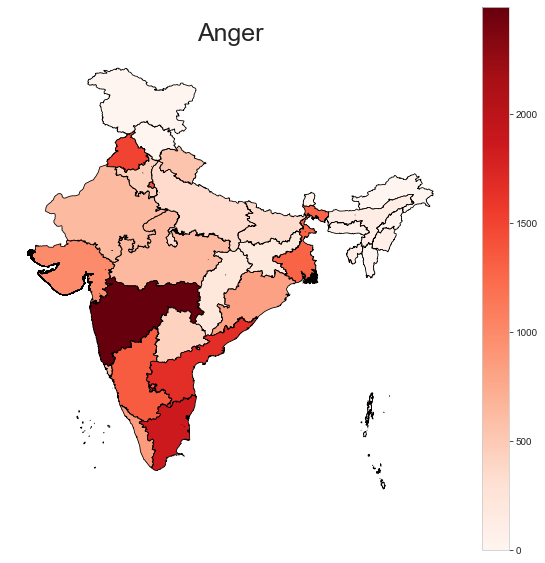

In [29]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Anger', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='anger',cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

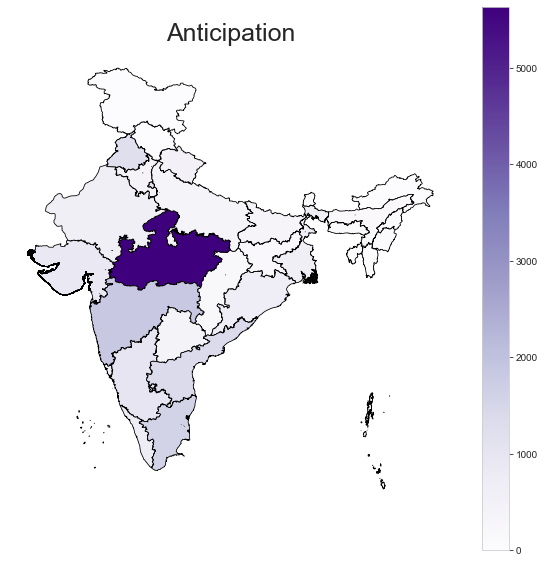

In [30]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Anticipation', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='anticipation',cmap='Purples', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

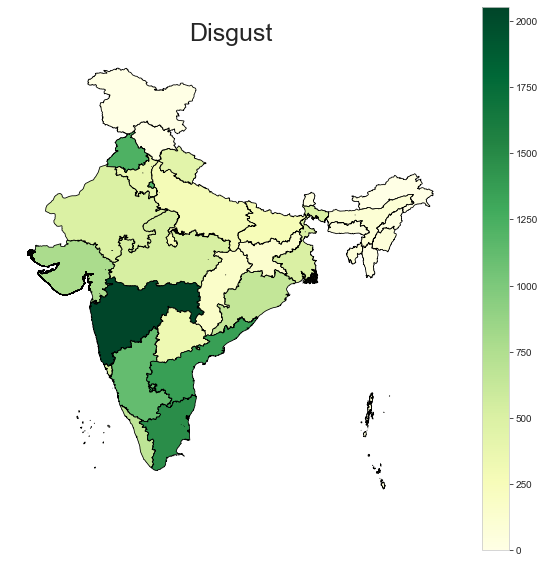

In [31]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Disgust', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='disgust',cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

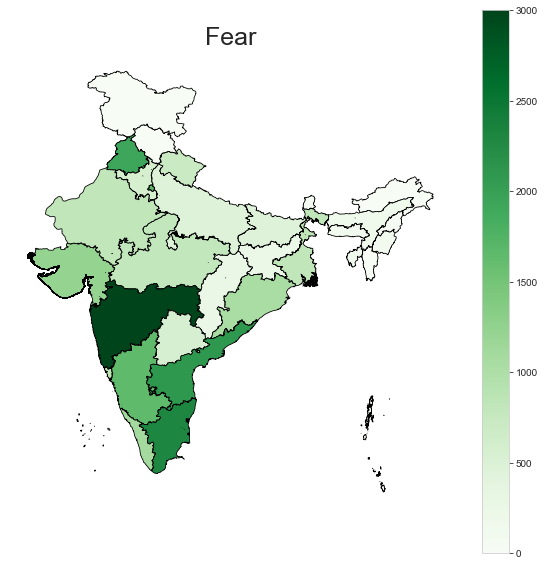

In [32]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Fear', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='fear',cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

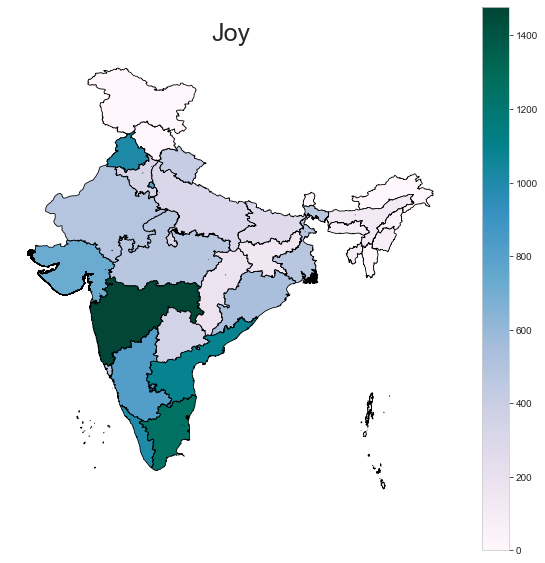

In [33]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Joy', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='joy',cmap='PuBuGn', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

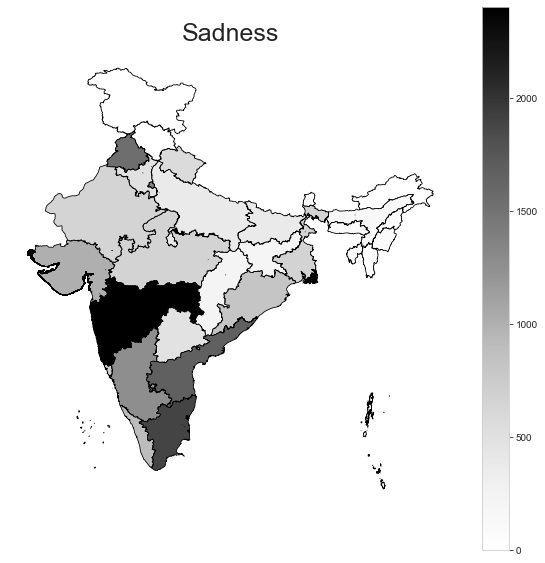

In [34]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Sadness', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='sadness',cmap='Greys', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

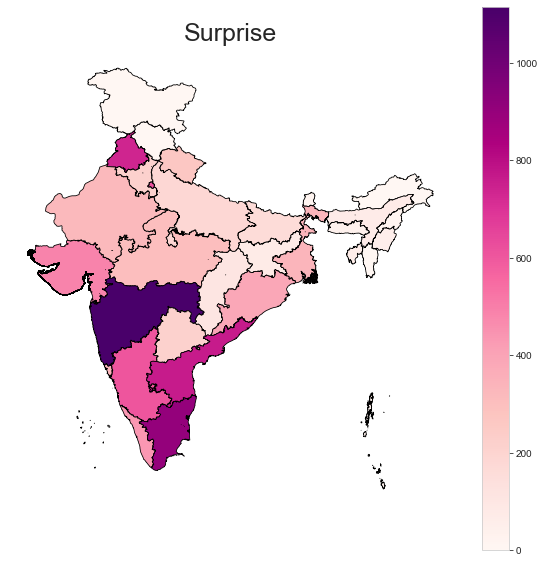

In [35]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Surprise', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='surprise',cmap='RdPu', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

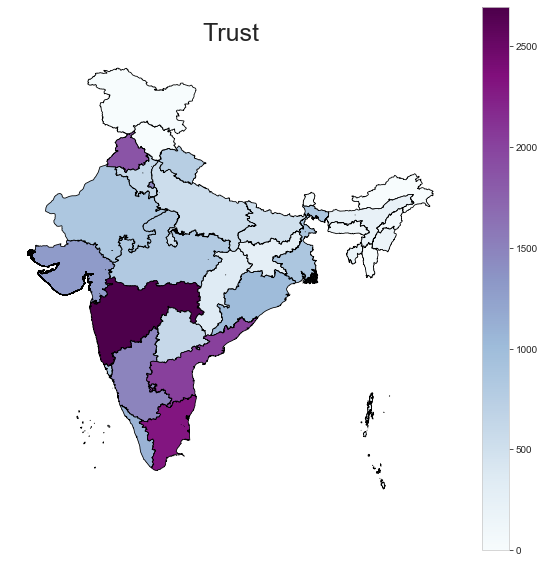

In [36]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Trust', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='trust',cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

In [37]:
def csv_timeline(state,csv_name):
    df = pd.read_csv(csv_name,encoding='latin1')
    lockdown1=[]
    lockdown2=[]
    lockdown3=[]
    lockdown4=[]
    df["Tweet Posted Time (UTC)"]= pd.to_datetime(df["Tweet Posted Time (UTC)"], format = "%d/%m/%Y")
    y1 = "25-03-2020"
    y2 = "14-04-2020"
    y3 = "15-04-2020"
    y4 = "03-05-2020"
    y5 = "4-05-2020"
    y6 = "17-05-2020"
    y7 = "18-05-2020"
    y8 = "31-05-2020"
    lock1 = df[ ( df['Tweet Posted Time (UTC)'] > pd.to_datetime(y1, format = "%d-%m-%Y")) & (df['Tweet Posted Time (UTC)'] < pd.to_datetime(y2, format = "%d-%m-%Y")) ]
    lock2 = df[ ( df['Tweet Posted Time (UTC)'] > pd.to_datetime(y3, format = "%d-%m-%Y")) & (df['Tweet Posted Time (UTC)'] < pd.to_datetime(y4, format = "%d-%m-%Y")) ]
    lock3 = df[ ( df['Tweet Posted Time (UTC)'] > pd.to_datetime(y5, format = "%d-%m-%Y")) & (df['Tweet Posted Time (UTC)'] < pd.to_datetime(y6, format = "%d-%m-%Y")) ]
    lock4 = df[ ( df['Tweet Posted Time (UTC)'] > pd.to_datetime(y7, format = "%d-%m-%Y")) & (df['Tweet Posted Time (UTC)'] < pd.to_datetime(y8, format = "%d-%m-%Y")) ]
    
    lockdown1=lock1['Tweet Content']
    lockdown2=lock2['Tweet Content']
    lockdown3=lock3['Tweet Content']
    lockdown4=lock4['Tweet Content']
    def clean(lockdown):
       #lowerCase
        lockdown = lockdown.map(lambda x:str(x).lower())

        #user mention removes
        lockdown = lockdown.str.replace(r'@\S+', '')

        #removes reTweet Content & cc
        lockdown = lockdown.str.replace(r'rt|cc', '')

        #remove special characters except [a-zA-Z]
        lockdown = lockdown.map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))

        #remove link starts with https
        lockdown = lockdown.map(lambda x:re.sub('http.*','',str(x)))

        lockdown = lockdown.str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')

        #punctuation
        lockdown = lockdown.str.replace('[{}]'.format(string.punctuation), '')


    

        # it include stopwords
        tweet_words = []
        for i in lockdown:
            for j in i.split():
                tweet_words.append(j)
    

        # here we remove stopwords
        fwords = []
        for i in tweet_words:
            if i not in stop:
                fwords.append(i)
        return fwords
        
    lockdown1=clean(lockdown1)
    lockdown2=clean(lockdown2)
    lockdown3=clean(lockdown3)
    lockdown4=clean(lockdown4)
    #return lockdown1,lockdown2,lockdown3,lockdown4

    def intersect(lockdown_list):
        common_words_emotion = list(set(emotion_word).intersection(set(lockdown_list)))
        

        NRC_words = []
        for i in emolex_words['word']:
            NRC_words.append(i)
        

        # Create your dictionary class  
        class my_dictionary(dict):  

            # __init__ function  
            def __init__(self):  
                self = dict()  

            # Function to add key:value  
            def add(self, key, value):  
                self[key] = value  

        def CountFrequency(my_list):
            dict_obj = my_dictionary() 
            for i in my_list:
                j = lockdown_list.count(i)
                # Taking input key = 1, value = Geek 
                dict_obj.key = i
                dict_obj.value = j
                dict_obj.add(dict_obj.key, dict_obj.value) 
            return dict_obj

    

        dictionary_emotion = CountFrequency(common_words_emotion)
       

        anger=0
        anticipation=0
        disgust=0
        fear=0
        joy=0
        sadness=0
        surprise=0
        trust=0

        for row in emolex_words.itertuples():
            for key,value in dictionary_emotion.items():
                if row[1] in key:
                    if (row.anger == 1):
                        anger += 1
                    if (row.anticipation == 1):
                        anticipation += 1
                    if (row.disgust == 1):
                        disgust += 1
                    if (row.fear == 1):
                        fear += 1
                    if (row.joy == 1):
                        joy +=1
                    if (row.sadness == 1):
                        sadness += 1
                    if (row.surprise == 1):
                        surprise += 1
                    if (row.trust == 1):
                        trust += 1
        lockdown_timeline_emotion_dict = {
                'anger':anger,
                'anticipation':anticipation,
                'disgust':disgust,
                'fear':fear,
                'joy':joy,
                'sadness':sadness,
                'surprise':surprise,
                'trust':trust
            }
        return lockdown_timeline_emotion_dict
    dict_lockdown1=intersect(lockdown1)
    dict_lockdown2=intersect(lockdown2)
    dict_lockdown3=intersect(lockdown3)
    dict_lockdown4=intersect(lockdown4)
    
    anger = [dict_lockdown1['anger'],dict_lockdown2['anger'],dict_lockdown3['anger'],dict_lockdown4['anger']]
    anticipation = [dict_lockdown1['anticipation'],dict_lockdown2['anticipation'],dict_lockdown3['anticipation'],dict_lockdown4['anticipation']]
    disgust = [dict_lockdown1['disgust'],dict_lockdown2['disgust'],dict_lockdown3['disgust'],dict_lockdown4['disgust']]
    fear = [dict_lockdown1['fear'],dict_lockdown2['fear'],dict_lockdown3['fear'],dict_lockdown4['fear']]
    joy = [dict_lockdown1['joy'],dict_lockdown2['joy'],dict_lockdown3['joy'],dict_lockdown4['joy']]
    sadness = [dict_lockdown1['sadness'],dict_lockdown2['sadness'],dict_lockdown3['sadness'],dict_lockdown4['sadness']]
    surprise = [dict_lockdown1['surprise'],dict_lockdown2['surprise'],dict_lockdown3['surprise'],dict_lockdown4['surprise']]
    trust = [dict_lockdown1['trust'],dict_lockdown2['trust'],dict_lockdown3['trust'],dict_lockdown4['trust']]

    import matplotlib.pyplot as plt
   
    Year = ['Lockdown 1','Lockdown 2','Lockdown 3','Lockdown 4']
    labels = ['anger','anticipation', 'disgust','fear', 'joy','sadness','surprise','trust']
    plt.plot(Year, anger)
    plt.plot(Year, anticipation)
    plt.plot(Year, disgust)
    plt.plot(Year, fear)
    plt.plot(Year, joy)
    plt.plot(Year, sadness)
    plt.plot(Year, surprise)
    plt.plot(Year, trust)

    plt.title('Time Line Analysis '+ '(' + state + ')')
    plt.xlabel('Lockdown')
    plt.ylabel('Emotion Score')
    plt.legend(labels,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    
    

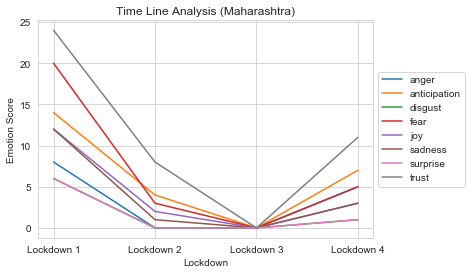

In [38]:
csv_timeline('Maharashtra','Maharashtra.csv')


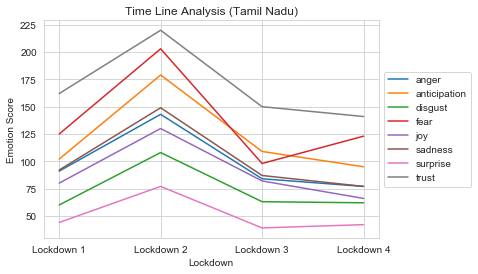

In [39]:
csv_timeline('Tamil Nadu','Tamil Nadu.csv')

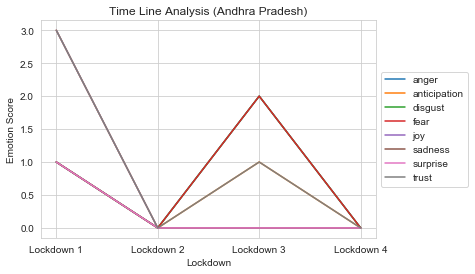

In [40]:
csv_timeline('Andhra Pradesh','Andhra Pradesh.csv')

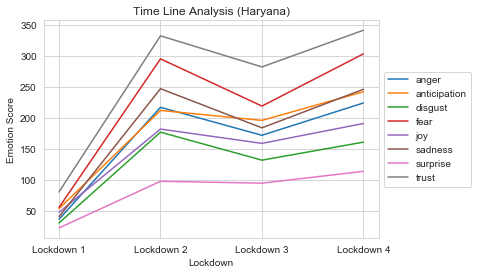

In [41]:
csv_timeline('Haryana','Haryana.csv')

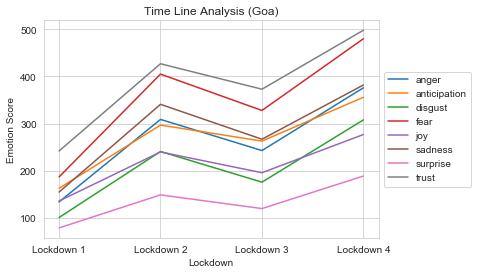

In [42]:
csv_timeline('Goa','Goa.csv')

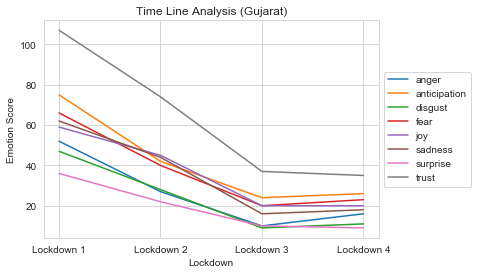

In [43]:
csv_timeline('Gujarat','Gujarat.csv')

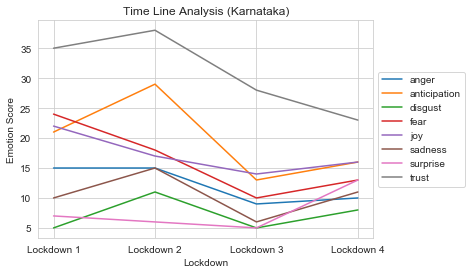

In [44]:
csv_timeline('Karnataka','Karnataka.csv')

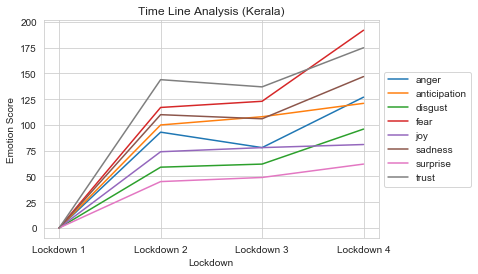

In [45]:
csv_timeline('Kerala','Kerala.csv')

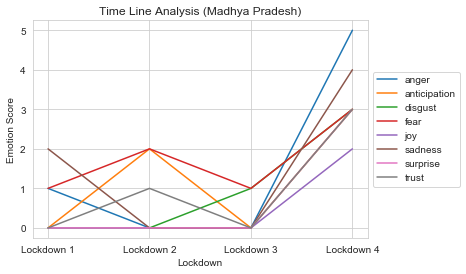

In [46]:
csv_timeline('Madhya Pradesh','Madhya Pradesh.csv')

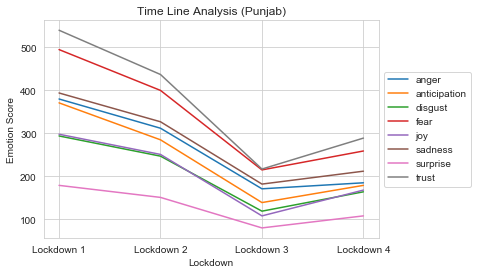

In [47]:
csv_timeline('Punjab','Punjab.csv')

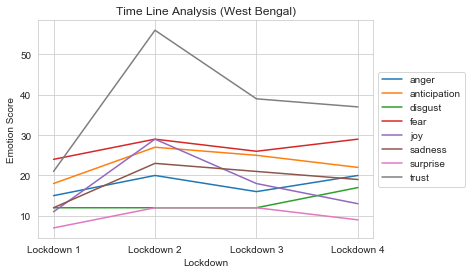

In [48]:
csv_timeline('West Bengal','West Bengal.csv')

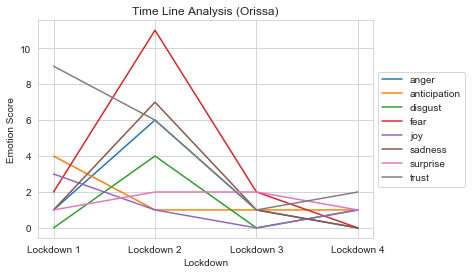

In [49]:
csv_timeline('Orissa','Orissa.csv')

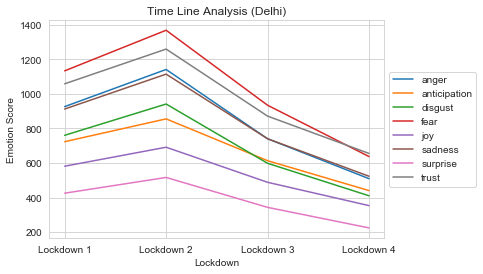

In [50]:
csv_timeline('Delhi','Delhi.csv')